# RNN 实现
#1.加载数据集
#2.使得数据集可以跌倒
#3.创建，初始化模型类
#4.初始化损失类
#5.训练模型

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
#下载数据集
trainsets = datasets.MNIST("data_mnist", train=True, download=True, transform=transforms.ToTensor())

testsets = datasets.MNIST("data_mnist", train=False, transform=transforms.ToTensor())

C:\Users\user\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
class_names = trainsets.classes #查看标签、类别

print(class_names)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [5]:
#查看数据集的大小shape

print(trainsets.data.shape)

torch.Size([60000, 28, 28])


In [6]:
print(trainsets.targets.shape)

torch.Size([60000])


In [7]:
print(testsets.data.shape)

torch.Size([10000, 28, 28])


In [8]:
print(testsets.targets.shape)

torch.Size([10000])


In [9]:
# 定义超参数
BATCH_SIZE = 16 #每批读取的数据大小
EPOCHS = 6 #训练10轮

In [10]:
#创建数据集的可迭代对象，也就是一个batchd的读取数据
train_loader = torch.utils.data.DataLoader(dataset=trainsets, batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=testsets, batch_size=BATCH_SIZE, shuffle=True)

In [11]:
#查看一批batch的数据

images,labels = next(iter(test_loader))
print(images.shape)
print(labels.shape)

torch.Size([16, 1, 28, 28])
torch.Size([16])


In [12]:
#定义函数，显示一批数据
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0)) #把大小放前面，颜色通道放到后面
    mean =  np.array([0.485,0.456,0.406]) #均值
    std = np.array([0.229,0.224,0.225]) #标准差
    inp = std*inp + mean  #将数据恢复过来，因为最开始换tensor的时候改变了
    inp = np.clip(inp,0,1) #将数据进行压缩,像素值在0和1之间
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

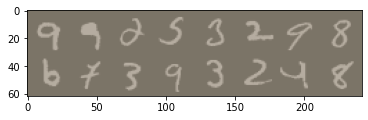

In [13]:
#网格方式进行显示
out = torchvision.utils.make_grid(images)
imshow(out)

In [14]:
#定义RNN'模型
class RNN_Model(nn.Module):
    def __init__(self,input_dim,hidden_dim,layer_dim,output_dim):
        super(RNN_Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        #Bbatch_first将中间的参数调到前面去
        self.rnn = nn.RNN(input_dim,hidden_dim,layer_dim, batch_first=True,nonlinearity='tanh')
        #全连接层
        self.fc = nn.Linear(hidden_dim,output_dim)
    
    def forward(self,x):
        #(layer_dim.batch_size,hidden_dim)
        h0 = torch.zeros(self.layer_dim,x.size(0),self.hidden_dim).requires_grad_().to(device)
        #分离隐藏状态，避免梯度爆炸
        out, hn = self.rnn(x,h0.detach())
        out = self.fc(out[:,-1,:])
        return out

In [15]:
#初始化模型
input_dim = 28 #输入维度
hidden_dim = 100 #隐层的维度
layer_dim = 2 #2层RNN
output_dim = 10 #输出维度

device = torch.device('cpu')

model = RNN_Model(input_dim,hidden_dim,layer_dim,output_dim).to(device)

In [16]:
#定义损失函数
criterion = nn.CrossEntropyLoss()

In [17]:
#定义优化器
learning_rate=0.001

optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)

In [18]:
#输出模型参数的信息
length =len(list(model.parameters()))
print(length)

10


In [19]:
#把模型参数打出来
for i in range(length):
    print('参数：%d'%(i+1))
    print(list(model.parameters())[i].shape)

参数：1
torch.Size([100, 28])
参数：2
torch.Size([100, 100])
参数：3
torch.Size([100])
参数：4
torch.Size([100])
参数：5
torch.Size([100, 100])
参数：6
torch.Size([100, 100])
参数：7
torch.Size([100])
参数：8
torch.Size([100])
参数：9
torch.Size([10, 100])
参数：10
torch.Size([10])


In [20]:
#模型训练
sequence_dim = 28 #序列长度,代表每张图片每行的像素点
loss_list = [] #保存损失
accuracy_list = [] #保存准确度
iteration_list = [] #保存循次数

iter = 0
for epoch in range(EPOCHS):
    for i,(images,labels) in enumerate(train_loader):
        model.train() #声明训练
        #一个batch的数据转化为RNN的输入维度
        images = images.view(-1,sequence_dim,input_dim).requires_grad_().to(device)
        labels = labels.to(device)
        #梯度清0，否则会不断累加
        optimizer.zero_grad()
        #前向传播
        outputs = model(images)
        #计算损失
        loss = criterion(outputs,labels)
        #反向传播
        loss.backward()
        #更新参数
        optimizer.step()
        #计数器自动加一
        iter +=1
        #模型验证
        if iter % 2000 == 0:
            model.eval() #声明，验证模型
            #验证准确度
            correct = 0.0
            total = 0.0
            #迭代测试集获取数据预测
            for images,labels in test_loader:
                images = images.view(-1,sequence_dim,input_dim).to(device)
                #模型预测
                predict = model(images)
                #获取预测概率最大值的下标
                predict = torch.max(outputs.data,1)[1]
                #统计测试集的大小
                total += labels.size(0)
                #统计判断，预测正确的数量
                correct += (predict == labels).sum()
                
            accuracy =correct/ total*100
            #保存
            loss_list.append(loss.data)
            accuracy_list.append(accuracy)
            iteration_list.append(iter)
            #打印信息
            print("loop:{}.Loss:{},Accuracy:{}".format(iter,loss.item(),accuracy))

loop:2000.Loss:2.301060199737549,Accuracy:11.24000072479248
loop:4000.Loss:2.29302978515625,Accuracy:10.390000343322754
loop:6000.Loss:2.1945745944976807,Accuracy:9.979999542236328
loop:8000.Loss:1.4861915111541748,Accuracy:10.239999771118164
loop:10000.Loss:0.9702692627906799,Accuracy:10.130000114440918
loop:12000.Loss:0.9191430807113647,Accuracy:10.199999809265137
loop:14000.Loss:0.899323582649231,Accuracy:9.929999351501465
loop:16000.Loss:1.177772045135498,Accuracy:10.329999923706055
loop:18000.Loss:0.7973325252532959,Accuracy:9.5600004196167
loop:20000.Loss:0.7958930134773254,Accuracy:9.920000076293945
loop:22000.Loss:0.504595935344696,Accuracy:10.019999504089355


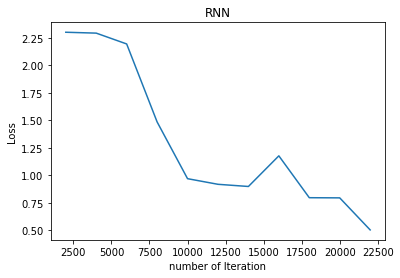

In [21]:
#可视化
plt.plot(iteration_list, loss_list)
plt.xlabel('number of Iteration')
plt.ylabel('Loss')
plt.title('RNN')
plt.show()

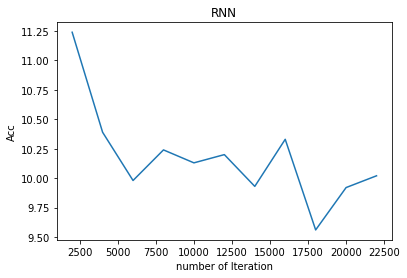

In [22]:
plt.plot(iteration_list,accuracy_list)
plt.xlabel('number of Iteration')
plt.ylabel('Acc')
plt.title('RNN')
plt.show()

LSTM 模型

In [23]:

class LSTM_Model(nn.Module):
    def __init__(self,input_dim,hidden_dim,layer_dim,output_dim):
        super(LSTM_Model,self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        #构建lstm模型
        self.lstm = nn.LSTM(input_dim,hidden_dim,layer_dim,batch_first=True)
        #全连接层
        self.fc = nn.Linear(hidden_dim,output_dim)
        
    def forward(self,x):
        #初始化隐层状态都为0
        h0 = torch.zeros(self.layer_dim,x.size(0),self.hidden_dim).requires_grad_()
        #初始化cell state
        c0 = torch.zeros(self.layer_dim,x.size(0),self.hidden_dim).requires_grad_()
        #分离隐藏状态，避免梯度爆炸
        out,(hn,cn) = self.lstm(x,(h0.detach(),c0.detach()))
        #只需要最后一层隐层的状态
        out = self.fc(out[:,-1,:])
        return out

In [24]:
#初始化模型
input_dim = 28
hidden_dim = 100
layer_dim = 1
output_dim = 10

model = LSTM_Model(input_dim,hidden_dim,layer_dim,output_dim)

device = torch.device('cpu')

In [25]:
#循环查看
for i in range(len(list(model.parameters()))):
    print("参数：%d"%(i+1))
    print(list(model.parameters())[i].size)

参数：1
<built-in method size of Parameter object at 0x0000022EFCD3E300>
参数：2
<built-in method size of Parameter object at 0x0000022E82CAEB00>
参数：3
<built-in method size of Parameter object at 0x0000022E82CB4E00>
参数：4
<built-in method size of Parameter object at 0x0000022E82CB4340>
参数：5
<built-in method size of Parameter object at 0x0000022EFFFCC400>
参数：6
<built-in method size of Parameter object at 0x0000022E82CB4AC0>


In [26]:
#初始化损失函数
criterion = nn.CrossEntropyLoss()

#优化器
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)

In [27]:
#模型训练

sequence_dim = 28
loss_list = []
accuracy_list = []
iteration_list = []
iter = 0
for epoch in range(EPOCHS):
    for i,(images,labels) in enumerate(train_loader):
        model.train()
        
        images = images.view(-1,sequence_dim,input_dim).requires_grad_().to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs,labels)
        
        loss.backward()
        
        optimizer.step()
        
        iter += 1
        
        if iter%2000 == 0:
            model.eval()
            correct = 0.0
            total = 0.0 
            for images,labels in test_loader:
                images = images.view(-1,sequence_dim,input_dim).to(device)
                outputs = model(images)
                predict = torch.max(outputs.data,1)[1]
                total += labels.size(0)
                correct += (predict == labels).sum()
                
            accuracy = correct / total *100
            loss_list.append(loss.data)
            accuracy_list.append(accuracy)
            iteration_list.append(iter)
            print("loop:{}.Loss:{},Accuracy:{}".format(iter,loss.item(),accuracy))

loop:2000.Loss:2.2721362113952637,Accuracy:12.449999809265137
loop:4000.Loss:2.300668954849243,Accuracy:18.34000015258789
loop:6000.Loss:2.189772605895996,Accuracy:29.339998245239258
loop:8000.Loss:1.893756628036499,Accuracy:45.59000015258789
loop:10000.Loss:0.7909048199653625,Accuracy:72.98999786376953
loop:12000.Loss:0.25427550077438354,Accuracy:85.7699966430664
loop:14000.Loss:0.37024274468421936,Accuracy:89.38999938964844
loop:16000.Loss:0.1732688695192337,Accuracy:92.94000244140625
loop:18000.Loss:0.22323401272296906,Accuracy:94.20999908447266
loop:20000.Loss:0.2712418735027313,Accuracy:95.38999938964844
loop:22000.Loss:0.3221069276332855,Accuracy:95.19000244140625


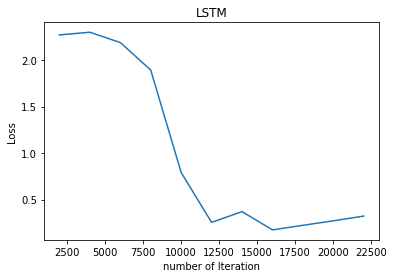

In [28]:
#可视化
plt.plot(iteration_list, loss_list)
plt.xlabel('number of Iteration')
plt.ylabel('Loss')
plt.title('LSTM')
plt.show()

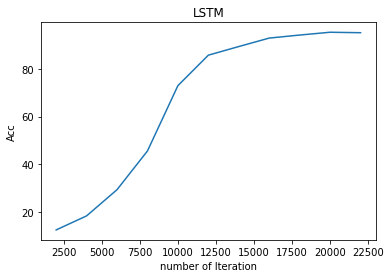

In [29]:
plt.plot(iteration_list,accuracy_list)
plt.xlabel('number of Iteration')
plt.ylabel('Acc')
plt.title('LSTM')
plt.show()